In [1]:
import numpy as np
import pandas as pd 
import warnings
import pickle
import wandb
import time
import tqdm

In [2]:
api = wandb.Api(timeout=60)
entity, project = 'the-real-dl', 'bio-transformers'
runs = api.runs(entity + '/' + project)
dataset = 'sine'

In [3]:
your_sweep_ids = [
    'mwg5vjm5', # sine-bp-adagrad
    '8ocsxge2', # sine-bp-adam
    'twk3ehwy', # sine-bp-rmsprop
    'ba3irv46', # sine-bp-momentum
    'wc9ctpq8', # sine-pc-adagrad-adam
    'xzk0ksen', # sine-pc-adam-adam
    'yumez8sz', # sine-pc-rmsprop-adam
    'xto93w0c', # sine-pc-momentum-adam
    '8kjc0an3', # sine-pc-adagrad-momentum
    'bmk5thrp', # sine-pc-adam-momentum
    'o7v5liv6', # sine-pc-rmsprop-momentum
    '5kxn6d81', # sine-pc-momentum-momentum
]

In [85]:
def metrics(run_id):
    r = api.run(f'{entity}/{project}/{run_id}')
    e = r.config['epochs']
    df = r.history(samples=r.config['epochs'] * 3)
    df = df[[col for col in df.columns if col in ['epoch', 'train_loss', 'test_loss', 'train_energy']]]
    df['c_loss'] = r.config['loss']
    df['c_dataset'] = r.config['dataset']
    df['c_training'] = r.config['training']
    return df

In [4]:
def extract(wandb_runs, maxrun=None):
    
    dfs = []
    count = 0

    for i, run in enumerate(runs):
        # time.sleep(2) # to avoid 429 Client Error
        print(f'Fetching run #{i}', end='\r')
        if maxrun is not None and count == maxrun: break

        summary = run.summary
        if not 'epoch' in summary.keys(): continue
        if run.state == 'running': continue
        if run.state == 'crashed': continue
        if run.state == 'failed': continue

        run_id = run.id
        sweep_id = run.sweep.id

        if sweep_id not in your_sweep_ids: continue

        config = run.config
        run_df = run.history()

        config.update({'sweep-id': sweep_id, 'run-id': run_id})
        summary.update({'sweep-id': sweep_id, 'run-id': run_id})

        l_epochs = []
        l_train_loss = []
        l_test_loss = []
        l_train_energy = []

        for e in range(summary['epoch']):
            x = run_df[run_df.epoch == e]
            if len(x.index) == 0: continue

            train_losses = x.train_loss.unique()
            test_losses = x.test_loss.unique()

            train_loss_no_nan = train_losses[~np.isnan(train_losses)]
            test_loss_no_nan = test_losses[~np.isnan(test_losses)]

            train_loss = train_loss_no_nan[0] if len(train_loss_no_nan) > 0 else np.nan
            test_loss = test_loss_no_nan[0] if len(test_loss_no_nan) > 0 else np.nan

            l_epochs.append(e)
            l_train_loss.append(train_loss)
            l_test_loss.append(test_loss)

            if config['training'] == 'pc':
                train_energies = x.train_energy.unique()
                train_energy_no_nan = train_energies[~np.isnan(train_energies)]
                train_energy = train_energy_no_nan[0] if len(train_energy_no_nan) > 0 else np.nan
                l_train_energy.append(train_energy)

            if config['training'] == 'bp':
                run_ids = np.full(len(l_epochs), run_id)
                sweep_ids = np.full(len(l_epochs), sweep_id)
                data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss))
                columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss']
            else:
                run_ids = np.full(len(l_epochs), run_id)
                sweep_ids = np.full(len(l_epochs), sweep_id)
                data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss, l_train_energy))
                columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss', 'train_energy']

        df = pd.DataFrame(data, columns=columns)

        # adding configs to df
        for k in list(config.keys())[:-2]:
            df['c_' + str(k)] = config[k]

        # adding summary to df
        for k in summary.keys():
            if k in ['_runtime', 'train_loss', 'test_loss', 'train_energy']:
                df['f_' + str(k)] = summary[k]

        dfs.append(df)
        count += 1


    print(f'Fetched {count} runs in {runs.entity}/{runs.project} (max runs: {"all" if maxrun is None else maxrun})')
    return pd.concat(dfs, axis=0).reset_index(drop=True)

In [5]:
def sort_runs_by_test_loss(df, top=None):
    x = df.drop(columns=['epoch', 'train_loss', 'test_loss', 'train_energy'])
    x = x.drop(columns=['c_loss', 'c_seed', 'c_model', 'c_wandb', 'c_device'])
    x = x.drop(columns=['c_epochs', 'c_dataset', 'c_dropout', 'c_batch-size'])

    if x.c_training.unique()[0] == 'bp':
        x = x.drop(columns=[c for c in list(x.columns) if c.startswith('c_pc')])
        x = x.drop(columns=['c_clr', 'c_init', 'c_iterations', 'c_x_optimizer', 'f_train_energy'])

    x = x.drop_duplicates().reset_index(drop=True)
    x = x.sort_values('f_test_loss', ascending=True).reset_index(drop=True)

    return x if top is None else x[:top]

In [6]:
def top_parameters(df):
    df_params = pd.DataFrame(columns=['parameter', 'abs_best', 'mean_best', 'median_best'])
    params = [c for c in df.columns if c.startswith('c')]

    for param in params:
        abs_best = df.loc[0, param]
        mean_best = df.groupby(param).agg({'f_test_loss': np.mean}).reset_index().iloc[0, 0]
        median_best = df.groupby(param).agg({'f_test_loss': np.median}).reset_index().iloc[0, 0]
        df_params = df_params.append({'parameter': param, 'abs_best': abs_best, 'mean_best': mean_best, 'median_best': median_best}, ignore_index=True)

    return df_params

In [7]:
def correlation_stats(df):
    corr_train_loss = df.corr()['train_loss']
    corr_test_loss = df.corr()['test_loss']
    corr_train_energy = df.corr()['train_energy']
    corr_train_loss = corr_train_loss[corr_train_loss.index.str.startswith(('c_'))].sort_values(ascending=False)
    corr_test_loss = corr_test_loss[corr_test_loss.index.str.startswith(('c_'))].sort_values(ascending=False)
    corr_train_energy = corr_train_energy[corr_train_energy.index.str.startswith(('c_'))].sort_values(ascending=False)
    return corr_train_loss, corr_test_loss, corr_train_energy

In [111]:
def plot_metrics(run_id):
    df = metrics(run_id)
    xlabel = 'epochs'
    ylabel = df.c_loss[0]
    title = f'{df.c_training[0]} {df.c_dataset[0]} run {run_id}'

    train_l = df[['epoch', 'train_loss']].dropna().train_loss
    train_loss =df[['epoch', 'train_loss']].dropna()[(train_l > np.quantile(train_l, 0.01)) & (train_l < np.quantile(train_l, 0.99))]

     # we can add fancy std-err visualizations and co.
    ax = train_loss.plot(x='epoch', legend='train loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), logy=True)
    df[['epoch', 'test_loss']].dropna().plot(x='epoch', legend='test loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), ax=ax, logy=True)
    if 'train_energy' in df.columns:
        df[['epoch', 'train_energy']].dropna().plot(x='epoch', legend='train energy', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), ax=ax, logy=True)

In [57]:
def plot_run(df, run_id):
    xlabel = 'epochs'
    ylabel = df[df.run_id == run_id].c_loss.unique()[0]
    title = f'{df[df.run_id == run_id].c_dataset.unique()[0]} run {run_id}'
    
    # we can add fancy std-err visualizations and co.
    df[df.run_id == run_id].train_loss.plot(x='epoch', legend='train loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4))
    df[df.run_id == run_id].test_loss.plot(x='epoch', legend='test loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4))
    if 'train_energy' in df[df.run_id == run_id].columns:
        df[df.run_id == run_id].train_energy.plot(x='epoch', legend='train energy', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4))

In [9]:
# with warnings.catch_warnings():
df = extract(runs, maxrun=None)
# df.to_csv(f'runs/{dataset}-wandb-runs.csv')

df_bp = df[(df.c_training == 'bp')]
df_pc = df[(df.c_training == 'pc')]

Fetched 988 runs in the-real-dl/bio-transformers (max runs: all)


In [10]:
top_bp = sort_runs_by_test_loss(df_bp, top=100)
top_pc = sort_runs_by_test_loss(df_pc, top=100)

In [11]:
top_bp[:5]

,sweep_id,run_id,c_lr,c_gamma,c_momentum,c_training,c_optimizer,c_batch_size,c_weight_decay,c_learning_rate,f__runtime,f_train_loss,f_test_loss
0,8ocsxge2,83gxz6be,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,198.273448,0.009827,0.011096
1,8ocsxge2,8pi7fi6o,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,279.505976,0.009827,0.011096
2,8ocsxge2,hmob9l7p,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,194.281385,0.009827,0.011096
3,8ocsxge2,xjq41ly1,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,218.819332,0.009827,0.011096
4,8ocsxge2,g9u9xnzi,0.005,NaN,NaN,bp,adam,128,0.0001,0.005,177.232922,0.013001,0.011411


In [12]:
top_pc[:5]

,sweep_id,run_id,c_lr,c_clr,c_init,c_gamma,c_pc_clr,c_pc_init,c_momentum,c_pc_gamma,...,c_x_optimizer,c_pc_optimizer,c_weight_decay,c_learning_rate,c_pc_weight_dacay,c_pc_weight_decay,f__runtime,f_train_loss,f_train_energy,f_test_loss
0,bmk5thrp,ew4b6dp0,0.0001,0.100,forward,NaN,0.100,forward,NaN,0.10,...,momentum,momentum,0.0010,0.0001,0.0005,0.0005,16897.905499,0.009328,0.000140,0.012254
1,5kxn6d81,a1pgogx9,0.0100,0.001,forward,0.1,0.001,forward,0.6,0.10,...,momentum,momentum,0.0001,0.0100,0.0010,0.0010,19995.364945,0.009674,0.000151,0.012454
2,8kjc0an3,t4ved44y,0.0100,0.100,forward,NaN,0.100,forward,NaN,0.10,...,momentum,momentum,0.0001,0.0100,0.0005,0.0005,17422.843938,0.009656,0.000595,0.012681
3,5kxn6d81,phhjch46,0.0100,0.001,forward,0.1,0.001,forward,0.6,0.01,...,momentum,momentum,0.0010,0.0100,0.0010,0.0010,22306.249457,0.009966,0.000160,0.012768
4,bmk5thrp,c990qwyi,0.0005,0.010,forward,NaN,0.010,forward,NaN,0.10,...,momentum,momentum,0.0000,0.0005,0.0005,0.0005,14383.891446,0.010137,0.000037,0.012881


In [13]:
top_parameters(top_bp)

,parameter,abs_best,mean_best,median_best
0,c_lr,0.005,0.0005,0.0005
1,c_gamma,NaN,0,0
2,c_momentum,NaN,0.3,0.3
3,c_training,bp,bp,bp
4,c_optimizer,adam,adam,adam
5,c_batch_size,128,32,32
6,c_weight_decay,0,0,0
7,c_learning_rate,0.005,0.0005,0.0005


In [14]:
top_parameters(top_pc)

,parameter,abs_best,mean_best,median_best
0,c_lr,0.0001,0.0001,0.0001
1,c_clr,0.1,0.0001,0.0001
2,c_init,forward,forward,forward
3,c_gamma,NaN,0,0
4,c_pc_clr,0.1,0.0001,0.0001
5,c_pc_init,forward,forward,forward
6,c_momentum,NaN,0,0
7,c_pc_gamma,0.1,0,0
8,c_pc_iters,50,50,50
9,c_training,pc,pc,pc


In [15]:
_, bp_corr_test_loss, _ = correlation_stats(df_bp)
_, pc_corr_test_loss, _ = correlation_stats(df_pc)

In [16]:
bp_corr_test_loss

c_momentum           0.009372
c_weight_decay       0.007165
c_batch_size         0.005524
c_batch-size         0.005524
c_learning_rate     -0.001971
c_lr                -0.001971
c_gamma             -0.009058
c_clr                     NaN
c_seed                    NaN
c_epochs                  NaN
c_pc_clr                  NaN
c_dropout                 NaN
c_pc_gamma                NaN
c_pc_iters                NaN
c_iterations              NaN
c_pc_momentum             NaN
c_pc_weight_dacay         NaN
c_pc_weight_decay         NaN
Name: test_loss, dtype: float64

In [17]:
pc_corr_test_loss

c_batch_size         0.028341
c_batch-size         0.028341
c_pc_momentum        0.021284
c_momentum           0.020654
c_learning_rate      0.005377
c_lr                 0.005377
c_weight_decay       0.004004
c_pc_weight_decay   -0.000084
c_pc_weight_dacay   -0.000084
c_gamma             -0.003361
c_epochs            -0.008403
c_pc_clr            -0.009657
c_clr               -0.009657
c_pc_gamma          -0.015229
c_seed                    NaN
c_dropout                 NaN
c_pc_iters                NaN
c_iterations              NaN
Name: test_loss, dtype: float64

### energy review

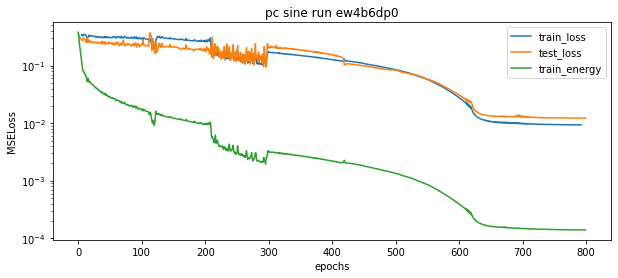

In [112]:
plot_metrics('ew4b6dp0')

### top bp-pc comparison

In [141]:
def plot_comparison(run_id_bp, run_id_pc):
    df = metrics(run_id_pc)
    df = df.rename(columns={"train_loss": "pc train loss", "test_loss": "pc eval loss"})
    xlabel = 'epochs'
    ylabel = df.c_loss[0]
    title = f'SINE BP vs. PC training convergence'

    train_l = df[['epoch', 'pc train loss']].dropna()['pc train loss']
    train_loss =df[['epoch', 'pc train loss']].dropna()[(train_l > np.quantile(train_l, 0.01)) & (train_l < np.quantile(train_l, 0.99))]
    epochs = list(range(df.epoch.max()))

    # we can add fancy std-err visualizations and co.
    ax = train_loss.plot(x='epoch', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), logy=True, color='tab:blue', linestyle='dashed')
    df[['epoch', 'pc eval loss']].dropna().plot(x='epoch', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), ax=ax, logy=True, color='tab:green', linestyle='dashed')

    df = metrics(run_id_bp)
    df = df[df.epoch.isin(epochs)]
    df = df.rename(columns={"train_loss": "bp train loss", "test_loss": "bp eval loss"})

    train_l = df[['epoch', 'bp train loss']].dropna()['bp train loss']
    train_loss = df[['epoch', 'bp train loss']].dropna()[(train_l > np.quantile(train_l, 0.01)) & (train_l < np.quantile(train_l, 0.99))]

    # we can add fancy std-err visualizations and co.
    train_loss.plot(x='epoch', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), ax=ax, logy=True, color='tab:blue')
    df[['epoch', 'bp eval loss']].dropna().plot(x='epoch', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), ax=ax, logy=True, color='tab:green')

In [138]:
top_bp[:10]

,sweep_id,run_id,c_lr,c_gamma,c_momentum,c_training,c_optimizer,c_batch_size,c_weight_decay,c_learning_rate,f__runtime,f_train_loss,f_test_loss
0,8ocsxge2,83gxz6be,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,198.273448,0.009827,0.011096
1,8ocsxge2,8pi7fi6o,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,279.505976,0.009827,0.011096
2,8ocsxge2,hmob9l7p,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,194.281385,0.009827,0.011096
3,8ocsxge2,xjq41ly1,0.005,NaN,NaN,bp,adam,128,0.0000,0.005,218.819332,0.009827,0.011096
4,8ocsxge2,g9u9xnzi,0.005,NaN,NaN,bp,adam,128,0.0001,0.005,177.232922,0.013001,0.011411
5,twk3ehwy,r7qm4778,0.001,0.0,0.6,bp,rmsprop,128,0.0001,0.001,191.298237,0.022110,0.011928
6,8ocsxge2,egjd4zud,0.005,NaN,NaN,bp,adam,64,0.0000,0.005,425.240541,0.011124,0.012289
7,8ocsxge2,rkgrdug5,0.005,NaN,NaN,bp,adam,64,0.0000,0.005,346.632836,0.011124,0.012289
8,8ocsxge2,91otgs5a,0.001,NaN,NaN,bp,adam,32,0.0000,0.001,457.377041,0.011916,0.013199
9,8ocsxge2,ksem49r9,0.001,NaN,NaN,bp,adam,32,0.0000,0.001,407.365156,0.011916,0.013199


In [145]:
top_pc[:10][['run_id', 'c_optimizer', 'c_x_optimizer', 'f_test_loss', 'c_batch_size', 'c_lr']]

,run_id,c_optimizer,c_x_optimizer,f_test_loss,c_batch_size,c_lr
0,ew4b6dp0,adam,momentum,0.012254,64,0.0001
1,a1pgogx9,momentum,momentum,0.012454,1,0.0100
2,t4ved44y,adagrad,momentum,0.012681,64,0.0100
3,phhjch46,momentum,momentum,0.012768,1,0.0100
4,c990qwyi,adam,momentum,0.012881,64,0.0005
5,9x25hnhx,momentum,momentum,0.013254,1,0.0050
6,nm3i7o0g,adagrad,momentum,0.013359,128,0.0100
7,xxeqrjsn,momentum,momentum,0.013745,1,0.0100
8,ufbk8jtc,adam,momentum,0.013852,64,0.0001
9,0n8wkgc2,adam,momentum,0.014438,64,0.0005


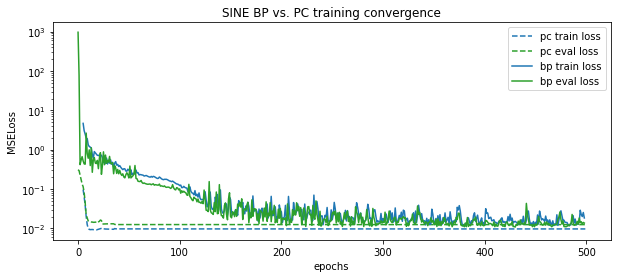

In [142]:
plot_comparison('r7qm4778', 'a1pgogx9')